## Text Classification with Natural Language Processing Methods and Machine Learning Examples
<a class="anchor" id="toc"></a>

### Table of Contents:

* [Read & Pre-Processing](#first)
* [Classification | Machine Learning | Classical | Research & Development](#second)
* [Classification Machine Learning Models](#third)

#### Importing of Libraries:

In [32]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from time import time
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix, f1_score
from statistics import mean
import pickle
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.models import load_model
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm as tq
import time
for i in tq(range(20), desc = 'tq() ### Library Importing Is Complete. ###'):
    time.sleep(0.5)

print('#####  IMPORTS COMPLETE  #####')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\p20226\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\p20226\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\p20226\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
tq() ### Library Importing Is Complete. ###: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]

#####  IMPORTS COMPLETE  #####


#### Data Pre-Processing
<a class="anchor" id="first"></a>
* [Table of Contents](#toc)

In [33]:
dataset = fetch_20newsgroups(subset ='train', 
                             remove=('headers', 'footers', 'quotes'), 
                             shuffle=True, 
                             random_state=42)

df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target

label = []

for i in df['source']:
    label.append(dataset.target_names[i])

df['label']=label

# Remove source feature as label will be encoded for dependant:
df.drop(['source'], axis = 1, inplace = True)

def label_targets(a):
    if a['label'] == 'talk.politics.misc' or a['label'] == 'talk.politics.guns' or a['label'] == 'talk.politics.mideast':
        return 'politics'

    elif a['label'] == 'rec.sport.hockey' or a['label'] == 'rec.sport.baseball':
        return 'sport'

    elif a['label'] == 'soc.religion.christian' or a['label'] == 'talk.religion.misc':
        return 'religion'

    elif a['label'] == 'comp.windows.x' or a['label'] == 'comp.sys.ibm.pc.hardware' or a['label'] == 'comp.os.ms-windows.misc' or a['label'] == 'comp.graphics' or a['label'] == 'comp.sys.mac.hardware':
        return 'computer'

    elif a['label'] == 'misc.forsale':
        return 'sales'

    elif a['label'] == 'rec.autos' or a['label'] == 'rec.motorcycles':
        return 'automobile'

    elif a['label'] == 'sci.crypt' or a['label'] == 'sci.electronics' or a['label'] == 'sci.space':
        return 'science'

    elif a['label'] == 'sci.med':
        return 'medicine'

    else:
        return 'ERROR'

df['label'] = df.apply(label_targets, axis = 1)

# Apply word count on text data:
df['Number_of_words'] = df['text'].apply(lambda x:len(str(x).split()))

# Drop all words that equal 0:
no_text = df[df['Number_of_words']==0]

# drop these rows
df.drop(no_text.index,inplace=True)

# cleaning the text:
def clean_text(text):

    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to  datasets
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
df['target'] = label_encoder.fit_transform(df['label'])

# Dataframe and NLP processing for ML models:
# Copy dataframe for ML model R&D:
df_ml = df.copy()

# Tokenize Text:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# Removing Stopwords:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

# Lemmatization:
lem = WordNetLemmatizer()
def lem_word(x):
    return [lem.lemmatize(w) for w in x]

def combine_text(list_of_text):

    '''Takes a list of text and combines them into one large chunk of text.'''
    
    combined_text = ' '.join(list_of_text)
    return combined_text

# Apply NLP functions to dataframe:
df_ml['tokens'] = df_ml['cleaned_text'].apply(lambda x:tokenizer.tokenize(x))
df_ml['stopwordremove_tokens'] = df_ml['tokens'].apply(lambda x : remove_stopwords(x))
df_ml['lemmatized_text'] = df_ml['stopwordremove_tokens'].apply(lem_word)    
df_ml['final_text'] = df_ml['lemmatized_text'].apply(lambda x : combine_text(x))

# Drop features not needed:
df_ml.drop(['cleaned_text','tokens','stopwordremove_tokens','lemmatized_text'], axis=1, inplace=True)
df_ml.reindex(columns = ['label','final_text','target'])

print('#####   DATA CLEASNING AND FEATURE ENGINEERING IS COMPLETE  #####')

#####   DATA CLEASNING AND FEATURE ENGINEERING IS COMPLETE  #####


In [34]:
df.head(3)
df_ml.head(3)

,text,label,Number_of_words,target,final_text
0,I was wondering if anyone out there could enli...,automobile,91,1,wondering anyone could enlighten car sawthe da...
1,A fair number of brave souls who upgraded thei...,computer,90,2,fair number brave soul upgraded si clock oscil...
2,"well folks, my mac plus finally gave up the gh...",computer,307,2,well folk mac plus finally gave ghost weekend ...


### Classification | Machine Learning | Classical | Research & Development
* [Table of Contents](#toc)
<a class="anchor" id="second"></a>

In [35]:
df['target'].unique()

array([1, 2, 7, 4, 3, 5, 6, 0, 8])

#### Vectorize and Split Dataset into X/y:

<AxesSubplot:xlabel='target', ylabel='count'>

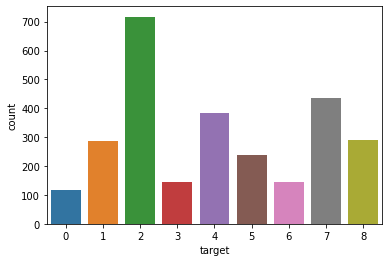

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

cv = CountVectorizer(max_features= 2000)
X= cv.fit_transform(df_ml['final_text']).toarray()
y= df_ml['target']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,stratify=y,random_state=4)

sns.countplot(y_test)

### Classification Machine Learning Models
* [Table of Contents](#toc)
<a class="anchor" id="third"></a>

In [37]:
# Variables for classification models:

LABELS = [8, 7, 6, 5, 4, 3, 2, 1, 0] # Used for accuracy labeling for predictions:

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

print("***RandomForest Classifier Model***")
rfc_model = RandomForestClassifier(n_estimators=1000,criterion='entropy')
rfc_model.fit(x_train,y_train)
y_pred = rfc_model.predict(x_test)
rfc_acc_score= accuracy_score(y_test,y_pred)
print("Accuracy Score:", round(rfc_acc_score * 100,2),"%")
print("Confusion Matrix")
rfc_cm = confusion_matrix(y_test, y_pred, labels=LABELS)
print(rfc_cm)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,y_pred,labels=LABELS)
print('Classification report for Random Classifier Model : \n',matrix)

***RandomForest Classifier Model***
Accuracy Score: 65.83 %
Confusion Matrix
[[228   9   0   1  18   0  24   8   2]
 [ 22 188   5   4  46   2 142  25   0]
 [  8   5  64   2   3   0  55   7   0]
 [ 13   3   0 157  37   2  18   4   4]
 [ 15  15   4   3 287   1  41  18   0]
 [  6  12   1   2  16  69  31   7   0]
 [ 23  12  13   3  12   0 642  12   0]
 [ 20  15   9   5  21   1  48 167   0]
 [  7   1   1  39  32   2  18   6  11]]
Classification report for Random Classifier Model : 
               precision    recall  f1-score   support

           8       0.67      0.79      0.72       290
           7       0.72      0.43      0.54       434
           6       0.66      0.44      0.53       144
           5       0.73      0.66      0.69       238
           4       0.61      0.75      0.67       384
           3       0.90      0.48      0.62       144
           2       0.63      0.90      0.74       717
           1       0.66      0.58      0.62       286
           0       0.65      0

In [39]:
from sklearn.naive_bayes import GaussianNB

print("***Naive Bayes Model***")
gnb_model = GaussianNB()
gnb_model.fit(x_train,y_train)
y_pred = gnb_model.predict(x_test)
gnb_acc_score= accuracy_score(y_test,y_pred)
print("Accuracy Score:", round(gnb_acc_score * 100,2),"%")
print("Confusion Matrix")
gnb_cm = confusion_matrix(y_test, y_pred, labels=LABELS)
print(gnb_cm)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,y_pred,labels=LABELS)
print('Classification report Naive Bayes Model : \n',matrix)

***Naive Bayes Model***
Accuracy Score: 45.32 %
Confusion Matrix
[[183   4  48   1  17   6   0   6  25]
 [ 20 187  68  14   5  29  41  36  34]
 [  4   5  84   2   5   7  23  11   3]
 [ 15   1  15  97  27   5   3   2  73]
 [ 28  16  40  54 148  13   1  28  56]
 [  3   8  15  11   9  63   3   5  27]
 [ 22  17 217   3   1  79 311  36  31]
 [ 25   7  84   5  11   5   9 117  23]
 [  3   0  17  23  14   0   0   2  58]]
Classification report Naive Bayes Model : 
               precision    recall  f1-score   support

           8       0.60      0.63      0.62       290
           7       0.76      0.43      0.55       434
           6       0.14      0.58      0.23       144
           5       0.46      0.41      0.43       238
           4       0.62      0.39      0.48       384
           3       0.30      0.44      0.36       144
           2       0.80      0.43      0.56       717
           1       0.48      0.41      0.44       286
           0       0.18      0.50      0.26       11

In [40]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

print("***Decision Tree Classifer Model***")
dtc_model = tree.DecisionTreeClassifier()
dtc_model.fit(x_train,y_train)
y_pred = dtc_model.predict(x_test)
dtc_acc_score= accuracy_score(y_test,y_pred)
print("Accuracy Score:", round(dtc_acc_score * 100,2),"%")
print("Confusion Matrix")
dtc_cm = confusion_matrix(y_test, y_pred, labels=LABELS)
print(dtc_cm)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,y_pred,labels=LABELS)
print('Classification reportDecision Tree Classifer Model : \n',matrix)

***Decision Tree Classifer Model***
Accuracy Score: 55.3 %
Confusion Matrix
[[206  17   2   5  18   6  26   7   3]
 [ 17 201  12   8  46  18  96  25  11]
 [ 11  19  54   3   4   2  42   9   0]
 [ 13  15   2 116  36   5  10  10  31]
 [ 30  48   6  20 208   7  29  20  16]
 [  5  11   4   4  16  67  22  12   3]
 [ 32  72  44  14  27   7 498  19   4]
 [ 24  28  12   9  28   7  31 143   4]
 [ 12   7   3  26  19   6   6   8  30]]
Classification reportDecision Tree Classifer Model : 
               precision    recall  f1-score   support

           8       0.59      0.71      0.64       290
           7       0.48      0.46      0.47       434
           6       0.39      0.38      0.38       144
           5       0.57      0.49      0.52       238
           4       0.52      0.54      0.53       384
           3       0.54      0.47      0.50       144
           2       0.66      0.69      0.67       717
           1       0.57      0.50      0.53       286
           0       0.29      0

### Neural Network Models | Research & Development

In [41]:
from tensorboard.plugins import projector
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

num_classes = len(df_ml["target"].value_counts())

y = tf.keras.utils.to_categorical(df["target"].values, num_classes=num_classes)
x_train, x_test, y_train, y_test = train_test_split(df_ml['final_text'], y, test_size=0.25)

# maximum number of words to keep
max_vocab_size = 20000

#instance of the Tokenizer class
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size)

# fit tokenizer on the train set
tokenizer.fit_on_texts(x_train)

# create numeric sequences for train and validation sets
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

def show_rand_seq(seq_index=0, seq_size=20):
    
  '''Display the first "seq_size" tokenized words of the text sample of index "seq_index" '''
  
  seq_len = seq_size if len(x_train.iloc[seq_index].split(" ")) > seq_size else len(x_train.iloc[seq_index].split(" "))
  seq_words = x_train.iloc[seq_index].split(" ")
  seq_ints = sequences_train[seq_index]
  for i in range(0, seq_len):
    pad = "\t" if len(seq_words[i]) > 7 else "\t\t"
    print(seq_words[i] + pad + "\u21d2 " + str(seq_ints[i]))

show_rand_seq()

# dictionary -> (word: integer)
wordindex_dict = tokenizer.word_index

# number of unique words
words = len(wordindex_dict)

# Padding:

data_train = pad_sequences(sequences_train)
sequence_length = data_train.shape[1]
data_test = pad_sequences(sequences_test, maxlen=sequence_length)

print('Shape of train tensor:', data_train.shape)
print('Shape of test tensor:', data_test.shape)

embedding_dimensionality = 30
hidden_state_dimensionality = 60

i = tf.keras.layers.Input(shape=(sequence_length,))
x = tf.keras.layers.Embedding(words+1, embedding_dimensionality)(i)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(i, x)

model.summary()

nominate	⇒ 16643
last		⇒ 74
bit		⇒ 124
antistathead	⇒ 765
quote		⇒ 47
weekalomar	⇒ 1166
point		⇒ 365
advantage	⇒ 6451
important	⇒ 3845
offensivecategory	⇒ 1902
baerga		⇒ 5580
studied		⇒ 552
joe		⇒ 2731
carter		⇒ 13796
school		⇒ 1490
outburninghas	⇒ 3113
impressive	⇒ 493
mediot		⇒ 1385
stats		⇒ 5836
largely		⇒ 16644
Shape of train tensor: (8260, 5966)
Shape of test tensor: (2754, 5966)


In [42]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=5, 
                                                      restore_best_weights=True)

METRICS = [  
      tf.keras.metrics.CategoricalAccuracy(name="accuracy")  
]

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=METRICS
)

model_fit=model.fit(
  data_train,
  y_train,
  epochs=50,
  validation_data=(data_test, y_test),
  callbacks=[earlystop_callback]
)

Epoch 1/50
259/259 [==============================] - 123s 474ms/step - loss: 1.9236 - accuracy: 0.3042 - val_loss: 1.6599 - val_accuracy: 0.5577
Epoch 2/50
259/259 [==============================] - 124s 480ms/step - loss: 1.2283 - accuracy: 0.6277 - val_loss: 1.1078 - val_accuracy: 0.6823
Epoch 3/50
259/259 [==============================] - 123s 474ms/step - loss: 0.8348 - accuracy: 0.7470 - val_loss: 0.9016 - val_accuracy: 0.7251
Epoch 4/50
259/259 [==============================] - 123s 476ms/step - loss: 0.6203 - accuracy: 0.8113 - val_loss: 0.8104 - val_accuracy: 0.7415
Epoch 5/50
259/259 [==============================] - 123s 477ms/step - loss: 0.4806 - accuracy: 0.8576 - val_loss: 0.7749 - val_accuracy: 0.7564
Epoch 6/50
259/259 [==============================] - 124s 478ms/step - loss: 0.3724 - accuracy: 0.8947 - val_loss: 0.7467 - val_accuracy: 0.7596
Epoch 7/50
259/259 [==============================] - 123s 474ms/step - loss: 0.2939 - accuracy: 0.9186 - val_loss: 0.7555 -

In [51]:
score, acc = model.evaluate(data_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

87/87 [==============================] - 6s 71ms/step - loss: 0.7455 - accuracy: 0.7669
Test score: 0.7455283403396606
Test accuracy: 0.7668845057487488


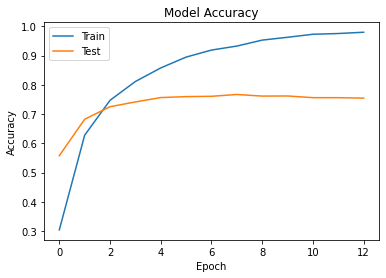

In [55]:
plt.plot(model_fit.history['accuracy'], label = 'Accuracy')
plt.plot(model_fit.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

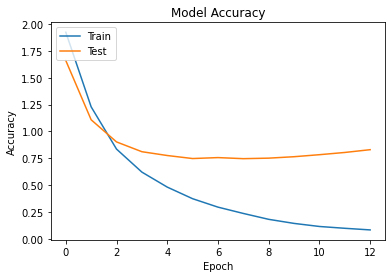

In [56]:
plt.plot(model_fit.history['loss'], label = 'Loss')
plt.plot(model_fit.history['val_loss'], label = 'Validation Loss')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [52]:
# compute confusion matrix with `tf` 
confusion = tf.math.confusion_matrix(
              labels = np.argmax(y_train, axis=1),      # get trule labels 
              predictions = np.argmax(y_pred, axis=1),  # get predicted labels 
              num_classes=num_classes) 

print(confusion)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [8260] != values[1].shape = [2754] [Op:Pack] name: stack

### Multi-Layer Perceptron | Classifier

In [ ]:
# set the indep and dep variable:
X = nn_test_2.loc[:, nn_test_2.columns != '2020_result']
y = nn_test_2.filter(['2020_result'])

# train and test split:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

parameter_space = {
    'hidden_layer_sizes': [(100,100,100)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.05],
    'learning_rate': ['adaptive'],
    'max_iter': [100],
    'random_state': [1],
    'batch_size': [20]
}

mlp = MLPClassifier()

clf = GridSearchCV(mlp, parameter_space, scoring='accuracy', cv=3)
clf.fit(X_train, y_train.values.ravel())

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results:  Uncomment to view all possible combinations based on acceptable results.
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

y_true, y_pred = y_test , clf.predict(X_test)

print('Results on the test set:')
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

#Get the confusion matrix
cf_matrix = confusion_matrix(y_true,y_pred)
print(cf_matrix)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

mlptest = str(clf.score(X_test, y_test))
mlptrain = str(clf.score(X_train, y_train))
print("score on test: " + mlptest)
print("score on train: " + mlptrain)

kf = KFold(n_splits=5)

print('K-Fold by 5 for model performance (results in % of accuracy)')
for train_indices, test_indices in kf.split(X):
    mlp.fit(X_train, y_train.values.ravel())
    print(mlp.score(X_test, y_test.values.ravel()))